## Load the dataset and preprocess

In [2]:
import pandas as pd

# Replace 'gene_expression.csv' with your file path or URL
df = pd.read_csv('/Volumes/Jagannath/Projects/algorithm_project/gene_expression_data.csv')
print(df.head())

        ensembl_id  PC3_Normoxia_S1  LNCAP_Hypoxia_S1  LNCAP_Hypoxia_S2  \
0  ENSG00000000003              348               609               693   
1  ENSG00000000005                0                 0                 0   
2  ENSG00000000419             1042              4390              4918   
3  ENSG00000000457               31               764               826   
4  ENSG00000000460              188               398               512   

   LNCAP_Normoxia_S2  PC3_Hypoxia_S1  PC3_Hypoxia_S2  PC3_Normoxia_S2  \
0                388            1075             333              964   
1                  0               0               0                0   
2               5766            3254            1030             2438   
3                654              91              25              101   
4                509             444             160              471   

   LNCAP_Normoxia_S1  
0                374  
1                  0  
2               4982  
3                5

In [3]:
# Check for missing values
print(df.isnull().sum())

ensembl_id           0
PC3_Normoxia_S1      0
LNCAP_Hypoxia_S1     0
LNCAP_Hypoxia_S2     0
LNCAP_Normoxia_S2    0
PC3_Hypoxia_S1       0
PC3_Hypoxia_S2       0
PC3_Normoxia_S2      0
LNCAP_Normoxia_S1    0
dtype: int64


In [5]:
print(df.dtypes)

ensembl_id           object
PC3_Normoxia_S1       int64
LNCAP_Hypoxia_S1      int64
LNCAP_Hypoxia_S2      int64
LNCAP_Normoxia_S2     int64
PC3_Hypoxia_S1        int64
PC3_Hypoxia_S2        int64
PC3_Normoxia_S2       int64
LNCAP_Normoxia_S1     int64
dtype: object


In [6]:
# Set 'ensembl_id' as the index
df = df.set_index('ensembl_id')

# Now, perform normalization (log2 transformation)
df_normalized = np.log2(df + 1)
print(df_normalized.head())

                 PC3_Normoxia_S1  LNCAP_Hypoxia_S1  LNCAP_Hypoxia_S2  \
ensembl_id                                                             
ENSG00000000003         8.447083          9.252665          9.438792   
ENSG00000000005         0.000000          0.000000          0.000000   
ENSG00000000419        10.026523         12.100334         12.264149   
ENSG00000000457         5.000000          9.579316          9.691744   
ENSG00000000460         7.562242          8.640245          9.002815   

                 LNCAP_Normoxia_S2  PC3_Hypoxia_S1  PC3_Hypoxia_S2  \
ensembl_id                                                           
ENSG00000000003           8.603626       10.071462        8.383704   
ENSG00000000005           0.000000        0.000000        0.000000   
ENSG00000000419          12.493605       11.668442       10.009829   
ENSG00000000457           9.355351        6.523562        4.700440   
ENSG00000000460           8.994353        8.797662        7.330917   

    

## Statistical Analysis

In [7]:
# Identify columns for each condition using keyword filtering
normoxia_cols = [col for col in df_normalized.columns if 'Normoxia' in col]
hypoxia_cols = [col for col in df_normalized.columns if 'Hypoxia' in col]

print("Normoxia columns:", normoxia_cols)
print("Hypoxia columns:", hypoxia_cols)

Normoxia columns: ['PC3_Normoxia_S1', 'LNCAP_Normoxia_S2', 'PC3_Normoxia_S2', 'LNCAP_Normoxia_S1']
Hypoxia columns: ['LNCAP_Hypoxia_S1', 'LNCAP_Hypoxia_S2', 'PC3_Hypoxia_S1', 'PC3_Hypoxia_S2']


In [8]:
# t-test for each gene
from scipy.stats import ttest_ind
# Define a function that performs a t-test for each gene (row)
def compute_ttest(row):
    normoxia_vals = row[normoxia_cols]
    hypoxia_vals = row[hypoxia_cols]
    t_stat, p_value = ttest_ind(normoxia_vals, hypoxia_vals, equal_var=False)
    return pd.Series({'t_stat': t_stat, 'p_value': p_value})

# Apply the t-test function row-wise
stats_df = df_normalized.apply(compute_ttest, axis=1)
print(stats_df.head())

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occ

                   t_stat   p_value
ensembl_id                         
ENSG00000000003 -0.829660  0.438487
ENSG00000000005       NaN       NaN
ENSG00000000419  0.004002  0.996938
ENSG00000000457 -0.039247  0.969993
ENSG00000000460  0.379888  0.717131


In [9]:
# Calculating Fold Change

# Compute mean expression values for each condition
df_normalized['mean_normoxia'] = df_normalized[normoxia_cols].mean(axis=1)
df_normalized['mean_hypoxia'] = df_normalized[hypoxia_cols].mean(axis=1)

# Calculate log2 fold change (since data is in log2 scale, the difference is the fold change)
df_normalized['log2_fold_change'] = df_normalized['mean_hypoxia'] - df_normalized['mean_normoxia']

In [10]:
# Combine t-test results with fold change data
results_df = pd.concat([stats_df, df_normalized[['mean_normoxia', 'mean_hypoxia', 'log2_fold_change']]], axis=1)
print(results_df.head())

                   t_stat   p_value  mean_normoxia  mean_hypoxia  \
ensembl_id                                                         
ENSG00000000003 -0.829660  0.438487       8.878960      9.286656   
ENSG00000000005       NaN       NaN       0.000000      0.000000   
ENSG00000000419  0.004002  0.996938      11.513750     11.510688   
ENSG00000000457 -0.039247  0.969993       7.560524      7.623765   
ENSG00000000460  0.379888  0.717131       8.642130      8.442910   

                 log2_fold_change  
ensembl_id                         
ENSG00000000003          0.407696  
ENSG00000000005          0.000000  
ENSG00000000419         -0.003062  
ENSG00000000457          0.063241  
ENSG00000000460         -0.199221  


## Custome scoring algorithm

we’ll create a score for each gene that combines its statistical significance (p-value) and magnitude of change (log₂ fold change). One common approach is to compute a score like:


\text{score} = -\log_{10}(\text{p-value}) \times |\text{log₂ fold change}|


This formula gives higher scores to genes that have both a low p-value (i.e., high significance) and a large change in expression.

Handling Special Cases
	•	P-values of 0 or NaN:
	•	We need to avoid taking the logarithm of 0.
	•	We can set a lower bound (e.g., replace p-values of 0 with a very small number) or return a score of 0 when the p-value is not valid.

In [11]:
import numpy as np
import pandas as pd

def custom_score(row):
    # Retrieve p-value and log2 fold change from the row
    p_val = row['p_value']
    log2_fc = row['log2_fold_change']
    
    # Check for invalid p-values (NaN or zero)
    if pd.isnull(p_val) or p_val <= 0:
        return 0  # or choose an alternative handling strategy
    
    # Calculate the negative log10 of the p-value
    neg_log_p = -np.log10(p_val)
    
    # Calculate the absolute value of the log2 fold change
    abs_log2_fc = abs(log2_fc)
    
    # Combine the two metrics to form the custom score
    score = neg_log_p * abs_log2_fc
    return score

# Apply the custom score function to each row in the results DataFrame
results_df['custom_score'] = results_df.apply(custom_score, axis=1)

# Preview the updated DataFrame
print(results_df.head())

                   t_stat   p_value  mean_normoxia  mean_hypoxia  \
ensembl_id                                                         
ENSG00000000003 -0.829660  0.438487       8.878960      9.286656   
ENSG00000000005       NaN       NaN       0.000000      0.000000   
ENSG00000000419  0.004002  0.996938      11.513750     11.510688   
ENSG00000000457 -0.039247  0.969993       7.560524      7.623765   
ENSG00000000460  0.379888  0.717131       8.642130      8.442910   

                 log2_fold_change  custom_score  
ensembl_id                                       
ENSG00000000003          0.407696      0.145973  
ENSG00000000005          0.000000      0.000000  
ENSG00000000419         -0.003062      0.000004  
ENSG00000000457          0.063241      0.000837  
ENSG00000000460         -0.199221      0.028768  


## Validation and visualization 

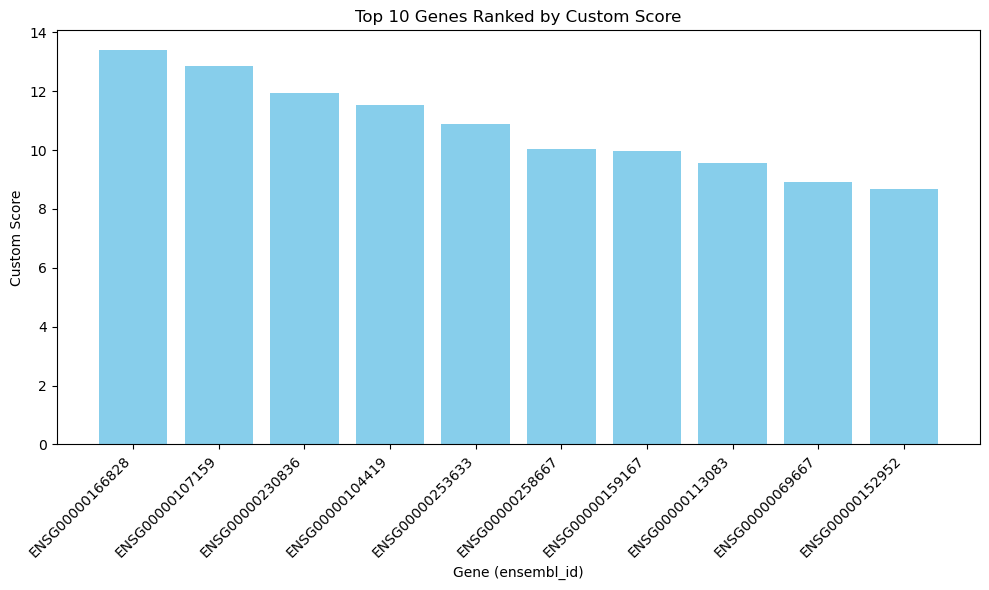

In [12]:
import matplotlib.pyplot as plt

# Sort the DataFrame by the custom_score in descending order and take the top 10 genes
top_genes = results_df.sort_values(by='custom_score', ascending=False).head(10)

# Create a bar plot for these top genes
plt.figure(figsize=(10, 6))
plt.bar(top_genes.index, top_genes['custom_score'], color='skyblue')
plt.xlabel('Gene (ensembl_id)')
plt.ylabel('Custom Score')
plt.title('Top 10 Genes Ranked by Custom Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

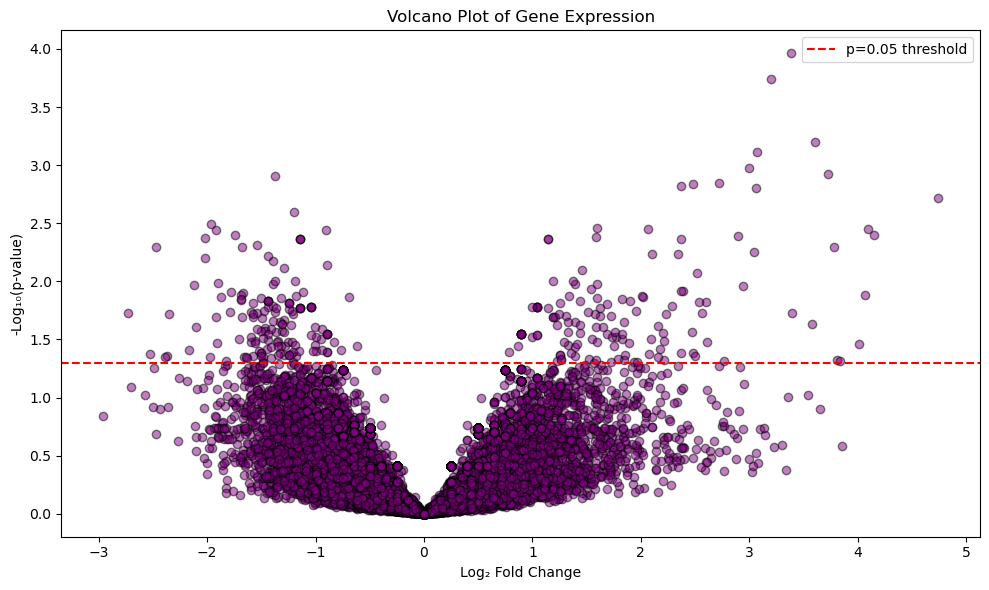

In [13]:
# Remove rows with invalid p-values (if any)
volcano_data = results_df[results_df['p_value'] > 0].copy()

plt.figure(figsize=(10, 6))
plt.scatter(volcano_data['log2_fold_change'], -np.log10(volcano_data['p_value']),
            alpha=0.5, c='purple', edgecolor='k')
plt.xlabel('Log₂ Fold Change')
plt.ylabel('-Log₁₀(p-value)')
plt.title('Volcano Plot of Gene Expression')
# Optional: add a horizontal line for p-value threshold (e.g., p=0.05)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05 threshold')
plt.legend()
plt.tight_layout()
plt.show()

## Test with simple classifier 

In [14]:
# Exclude the extra columns we added during statistical analysis
sample_cols = [col for col in df_normalized.columns 
               if col not in ['mean_normoxia', 'mean_hypoxia', 'log2_fold_change']]

# Create a DataFrame with only expression data
df_expression = df_normalized[sample_cols]

# Assume 'results_df' contains our ranking and that the index (ensembl_id) is the gene identifier.
# Get the top 10 genes based on the custom score:
top_genes = results_df.sort_values(by='custom_score', ascending=False).head(10).index.tolist()

# Extract expression values for the top genes and transpose: rows -> samples, columns -> genes.
X = df_expression.loc[top_genes].T

# Inspect the feature matrix:
print("Feature matrix shape:", X.shape)
print(X.head())

Feature matrix shape: (8, 10)
ensembl_id         ENSG00000166828  ENSG00000107159  ENSG00000230836  \
PC3_Normoxia_S1           5.954196         2.321928         1.000000   
LNCAP_Hypoxia_S1          9.659996         6.714246         5.087463   
LNCAP_Hypoxia_S2          9.396605         6.845490         4.754888   
LNCAP_Normoxia_S2         6.629357         3.169925         1.584963   
PC3_Hypoxia_S1           10.634811         9.321928         5.044394   

ensembl_id         ENSG00000104419  ENSG00000253633  ENSG00000258667  \
PC3_Normoxia_S1          11.326429         0.000000         5.643856   
LNCAP_Hypoxia_S1         15.855233         5.357552        10.659996   
LNCAP_Hypoxia_S2         15.901621         4.754888        10.559377   
LNCAP_Normoxia_S2        13.280626         0.000000         5.614710   
PC3_Hypoxia_S1           17.117156         4.459432         9.625709   

ensembl_id         ENSG00000159167  ENSG00000113083  ENSG00000069667  \
PC3_Normoxia_S1           8.6899

In [15]:
# Define a function to assign labels
def assign_label(sample_name):
    if 'Normoxia' in sample_name:
        return 0
    elif 'Hypoxia' in sample_name:
        return 1
    else:
        return -1  # For any unexpected naming; ideally this doesn't happen.

# Apply the function to the sample names (which are the index of X)
y = [assign_label(sample) for sample in X.index]

# Check the distribution of labels:
import pandas as pd
print(pd.Series(y).value_counts())

0    4
1    4
Name: count, dtype: int64


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

In [17]:
# Compute the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



### Classifier validation is optional, we created synthetic data for testing purpose. 

Simulated raw counts (first 5 rows):
        ensembl_id  Normoxia_S1  Normoxia_S2  Normoxia_S3  Normoxia_S4  \
0  ENSG00000000001           96          107           88          103   
1  ENSG00000000002          103           84           76           97   
2  ENSG00000000003           94          116           97           91   
3  ENSG00000000004          103           78          116           88   
4  ENSG00000000005           84          115           95          114   

   Normoxia_S5  Normoxia_S6  Normoxia_S7  Normoxia_S8  Normoxia_S9  ...  \
0          111           90           94           98          103  ...   
1          111           93           87          108          106  ...   
2           94          118          104          110          115  ...   
3          105           92           96          104           84  ...   
4          104           89          103           85          101  ...   

   Hypoxia_S1  Hypoxia_S2  Hypoxia_S3  Hypoxia_S4  Hypoxia_S5  Hypo

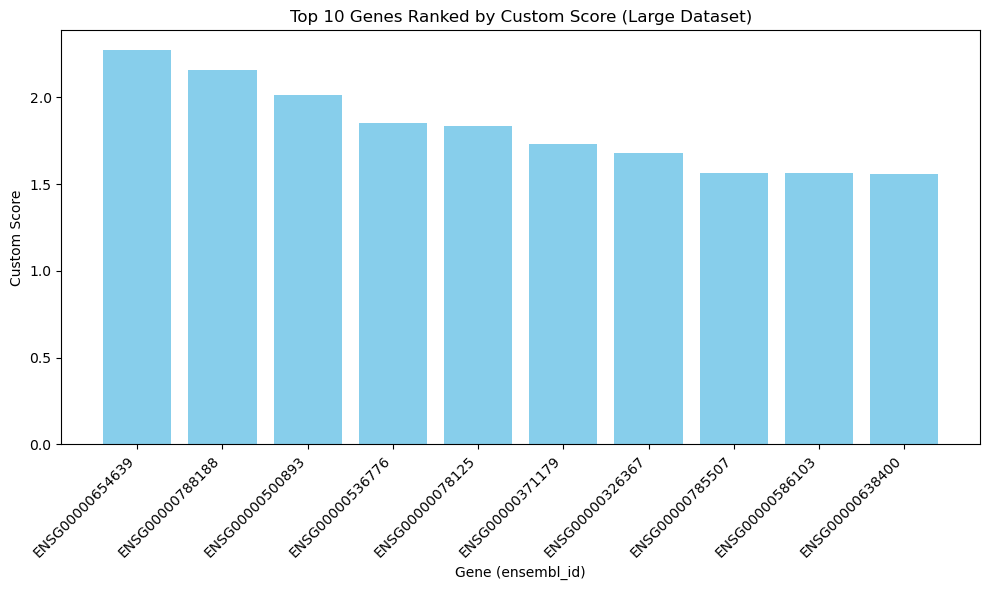

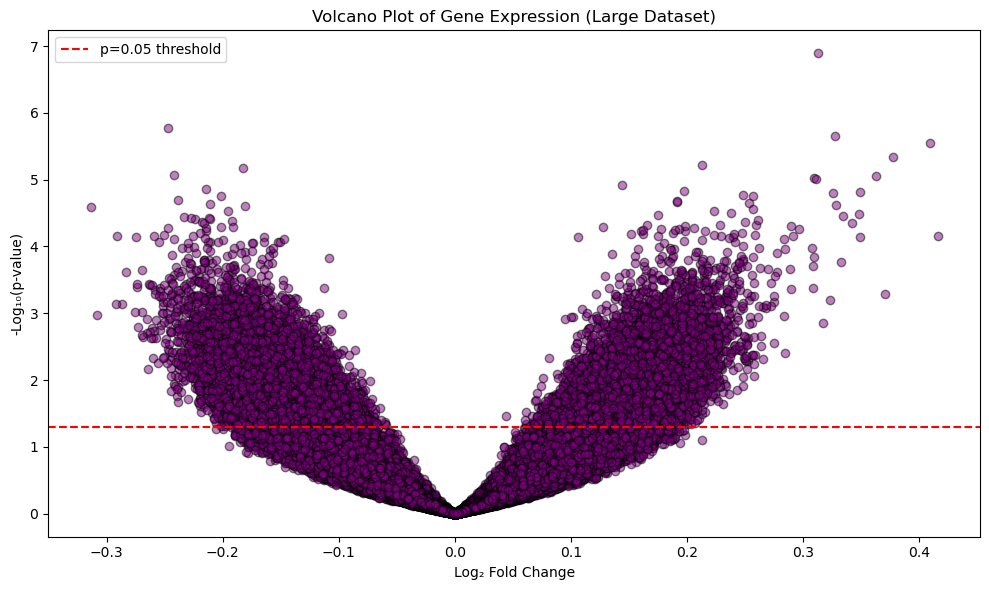


Feature matrix shape (samples x genes): (20, 10)
Label distribution: 0    10
1    10
Name: count, dtype: int64

Classifier Accuracy on Larger Dataset: 1.0

Classification Report on Larger Dataset:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# 1. Simulate a Larger Dataset
# -------------------------------
# Parameters for simulation
num_genes = 1000000
num_normoxia = 10
num_hypoxia = 10
total_samples = num_normoxia + num_hypoxia

# Create gene IDs
genes = [f'ENSG{str(i).zfill(11)}' for i in range(1, num_genes+1)]
# Create sample names
normoxia_samples = [f'Normoxia_S{i}' for i in range(1, num_normoxia+1)]
hypoxia_samples = [f'Hypoxia_S{i}' for i in range(1, num_hypoxia+1)]
all_samples = normoxia_samples + hypoxia_samples

# Simulate raw count data using Poisson distribution
np.random.seed(42)
df_counts = pd.DataFrame(
    np.random.poisson(lam=100, size=(num_genes, total_samples)),
    index=genes,
    columns=all_samples
)

# Introduce differential expression in 50 random genes (add extra counts in hypoxia)
diff_genes = np.random.choice(genes, 50, replace=False)
df_counts.loc[diff_genes, hypoxia_samples] += 20

# Reset index to have a column for gene IDs
df_counts.reset_index(inplace=True)
df_counts.rename(columns={'index': 'ensembl_id'}, inplace=True)

print("Simulated raw counts (first 5 rows):")
print(df_counts.head())

# -------------------------------
# 2. Data Normalization
# -------------------------------
# Set ensembl_id as index
df_large = df_counts.set_index('ensembl_id')

# Apply log2 transformation (adding 1 to avoid log(0))
df_large_normalized = np.log2(df_large + 1)
print("\nNormalized data (first 5 rows):")
print(df_large_normalized.head())

# -------------------------------
# 3. Differential Expression Analysis
# -------------------------------
# Identify sample columns by condition
normoxia_cols = [col for col in df_large_normalized.columns if 'Normoxia' in col]
hypoxia_cols = [col for col in df_large_normalized.columns if 'Hypoxia' in col]

# Function to compute t-test statistics for each gene
def compute_ttest(row):
    norm_vals = row[normoxia_cols]
    hyp_vals = row[hypoxia_cols]
    t_stat, p_val = ttest_ind(norm_vals, hyp_vals, equal_var=False)
    return pd.Series({'t_stat': t_stat, 'p_value': p_val})

# Apply t-test row-wise
stats_df = df_large_normalized.apply(compute_ttest, axis=1)

# Calculate mean expression for each condition and log2 fold change
df_large_normalized['mean_normoxia'] = df_large_normalized[normoxia_cols].mean(axis=1)
df_large_normalized['mean_hypoxia'] = df_large_normalized[hypoxia_cols].mean(axis=1)
df_large_normalized['log2_fold_change'] = df_large_normalized['mean_hypoxia'] - df_large_normalized['mean_normoxia']

# Combine statistics into one DataFrame
results_large = pd.concat([stats_df, 
                           df_large_normalized[['mean_normoxia', 'mean_hypoxia', 'log2_fold_change']]],
                          axis=1)

# -------------------------------
# 4. Custom Scoring Algorithm
# -------------------------------
def custom_score(row):
    p_val = row['p_value']
    log2_fc = row['log2_fold_change']
    # Handle cases where p-value is zero or NaN
    if pd.isnull(p_val) or p_val <= 0:
        return 0
    return -np.log10(p_val) * abs(log2_fc)

results_large['custom_score'] = results_large.apply(custom_score, axis=1)
print("\nDifferential expression results (first 5 rows):")
print(results_large.head())

# -------------------------------
# 5. Visualizing Top Genes
# -------------------------------
# Bar plot for top 10 genes
top_genes_large = results_large.sort_values(by='custom_score', ascending=False).head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_genes_large.index, top_genes_large['custom_score'], color='skyblue')
plt.xlabel('Gene (ensembl_id)')
plt.ylabel('Custom Score')
plt.title('Top 10 Genes Ranked by Custom Score (Large Dataset)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Volcano plot
volcano_data = results_large[results_large['p_value'] > 0].copy()
plt.figure(figsize=(10, 6))
plt.scatter(volcano_data['log2_fold_change'], -np.log10(volcano_data['p_value']),
            alpha=0.5, c='purple', edgecolor='k')
plt.xlabel('Log₂ Fold Change')
plt.ylabel('-Log₁₀(p-value)')
plt.title('Volcano Plot of Gene Expression (Large Dataset)')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p=0.05 threshold')
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# 6. Classifier Validation with Logistic Regression
# -------------------------------
# Prepare the expression matrix for the top genes
# First, extract only the sample columns from the normalized data
sample_cols = [col for col in df_large_normalized.columns 
               if col not in ['mean_normoxia', 'mean_hypoxia', 'log2_fold_change']]

# Create a DataFrame with only expression values
df_expression_large = df_large_normalized[sample_cols]

# Use the top 10 genes based on custom score as features
top_genes_list = top_genes_large.index.tolist()
# Extract the expression values for these genes and transpose so rows are samples, columns are genes
X_large = df_expression_large.loc[top_genes_list].T

# Create labels: 0 for Normoxia, 1 for Hypoxia (using sample names)
def assign_label(sample_name):
    if 'Normoxia' in sample_name:
        return 0
    elif 'Hypoxia' in sample_name:
        return 1
    else:
        return -1

y_large = [assign_label(sample) for sample in X_large.index]

print("\nFeature matrix shape (samples x genes):", X_large.shape)
print("Label distribution:", pd.Series(y_large).value_counts())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_large, y_large, test_size=0.3, random_state=42)

# Train logistic regression classifier
clf_large = LogisticRegression(max_iter=1000)
clf_large.fit(X_train, y_train)

# Predict on the test set
y_pred_large = clf_large.predict(X_test)

# Evaluate the classifier
accuracy_large = accuracy_score(y_test, y_pred_large)
print("\nClassifier Accuracy on Larger Dataset:", accuracy_large)
print("\nClassification Report on Larger Dataset:")
print(classification_report(y_test, y_pred_large))